# Classical PDE Solver Methods for Panel Buckling PDEs

Find the function w(x,y) and the eigenvalue $\lambda$ for transverse displacement of a plate such that on $\Omega = \{ (x,y) : 0 \leq x \leq a, \ 0 \leq y \leq b \}$ the PDE is satisfied. The constants $N_{xx}, N_{xy}, N_{yy}$ are prescribed by the user by loading type.
$$ D \nabla^4 w + \lambda ( N_{xx} \frac{\partial^2 w}{\partial x^2} + 2 N_{xy} \frac{\partial^2 w}{\partial x \partial y} + N_{yy} \frac{\partial^2 w}{\partial y^2} ) = 0 $$
And on the boundary $\partial \Omega$ we have simply supported BCs $w = 0$.

We will then use finite elements to solve this problem. First, we need to write the weak form with the test function $\delta w(x,y)$ in order to find a more suitable form for integration.
 
## Term 1 of the Weak Form
Term 1 of the weak form integral is:
$$ \int D \nabla^4 w \cdot \delta w dA = \int D (\frac{\partial^4 w}{\partial x^4} + 2 \frac{\partial^4 w}{\partial x^2 \partial y^2} + \frac{\partial^4 w}{\partial y^4} ) \cdot \delta w dA$$

The full expansion of this term is for each case:
$$ \int \frac{\partial^4 w}{\partial x^4} \cdot \delta w dx = (\frac{\partial^3 w}{\partial x^3} \delta w)|_{\partial \Omega} - (\frac{\partial^2 w}{\partial x^2} \frac{\partial \delta w}{\partial x})|_{\partial \Omega} + \int \frac{\partial^2 w}{\partial x^2} \frac{\partial^2 \delta w}{\partial x^2} dx $$
Since we have $w = 0$ on the boundary for simply supported and no moments on free edges for simply supported edges, the boundary terms are zero. WLOG, we can show that the full integral of term 1 of the weak form is:
$$ \int D \nabla^4 w \cdot \delta w dA = \int D \nabla^2 w \nabla^2 \delta w dA $$

## Term 2 of the Weak Form
The second term of the weak form involves user-prescribed constants $N_{ij}$ the in-plane loads and then we have:
$$ \int \left[ N_{xx} \frac{\partial^2 w}{\partial x^2} + 2 N_{xy} \frac{\partial^2 w}{\partial x \partial y} + N_{yy} \frac{\partial^2 w}{\partial y^2} \right] \delta w dA$$
By a similar argument, the boundary terms after integrating by parts are all zero as $\delta w = 0$ on the boundary. Then we have:
$$ - \int \left[ N_{xx} \frac{\partial w}{\partial x} \frac{\partial \delta w}{\partial x} + N_{xy} (\frac{\partial w}{\partial x} \frac{\partial \delta w}{\partial y} + \frac{\partial w}{\partial y} \frac{\partial \delta w}{\partial x}) + N_{yy} \frac{\partial w}{\partial y} \frac{\partial \delta w}{\partial y} \right] dA $$

## Finite Element Matrix
### Basis functions
Was originally using a quadratic element with 9-nodes and 2x2 Gauss quadrature. However, that gave really poor buckling mode estimates as it doesn't result in zero moments at the ends of the plate. I need to use higher-order elements like hermite cubic element (what we do for beams) in order to ensure zero moments at the end of the plate for the simply supported boundary condition. Otherwise I would have to use a penalty method to enforce zero moment constraint. I also need to use a 3x3 or 4x4 Gauss quadrature rule here.


Then we need to compute the integrals on a single element:
$$ K_{ij} = \int D \nabla^2 \phi_i \nabla^2 \phi_j dA $$

And the stability matrix $G_{ij}$ below whose shear term is symmetric!
$$ G_{ij} = \int N_{xx} \partial_{x} \phi_i \partial_{x} \phi_j + N_{xy} \cdot (\partial_x \phi_i \partial_y \phi_j + \partial_y \phi_i \cdot \partial_x \phi_j) + N_{yy} \partial_{y} \phi_i \partial_{y} \phi_j dA $$

## Gaussian Quadrature
The integral of an arbitrary 2D function $f(x,y)$ over a quadrilateral can be approximated as:
$$ \int f(x,y) dx dy \approx \sum_{q \in Q} w_q f(x_q, y_q) $$
Where the Gauss quadrature rule for 4 quadrature points on a quadrilateral is:
$$ w_q = \{ 1, 1, 1, 1 \} $$
And the quadrature points are:
$$ (x_q, y_q) = (\pm 1/\sqrt{3}, \pm 1/\sqrt{3}) $$

## Compute Element Stiffness and Stability Matrices
Convert the derivatives to isoperimetric space or computational coordinate space $\xi = 2 (x - x_c) / \Delta x, \eta = 2( y - y_c) / \Delta y$ so that $\xi \in [-1, 1]$ on the element and $\eta \in [-1,1]$ on the element. The differentials conversion is then: $ dx = \Delta x / 2 \cdot d \xi$, $dy = \Delta y / 2 \cdot d \eta $.

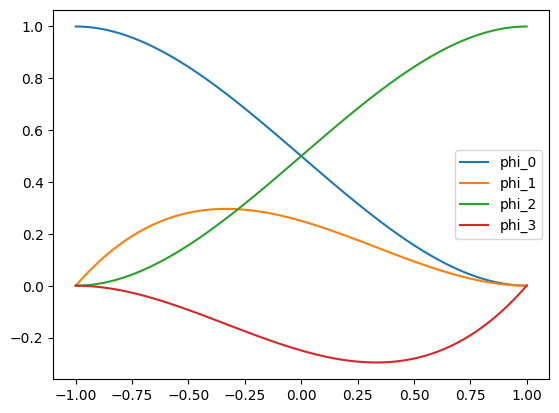

In [13]:
# check and plot the hermite cubic polynomials in 1d
import matplotlib.pyplot as plt
import numpy as np

def hermite_cubic_polynomials_1d(ibasis):
    # node 1 is xi = -1, node 2 is xi = 1
    if ibasis == 0: # w for node 1
        return [0.5, -0.75, 0.0, 0.25]
    elif ibasis == 1: # dw/dx for node 1
        return [0.25, -0.25, -0.25, 0.25]
    elif ibasis == 2: # w for node 2
        return [0.5, 0.75, 0.0, -0.25]
    elif ibasis == 3: # dw/dx for node 2
        return [-0.25, -0.25, 0.25, 0.25]
    
def eval_polynomial(poly_list, value):
    poly_list_arr = np.array(poly_list)
    var_list_arr = np.array([value**(ind) for ind in range(len(poly_list))])
    return np.dot(poly_list_arr, var_list_arr)

def hermite_cubic_1d(ibasis, xi):
    poly_list = hermite_cubic_polynomials_1d(ibasis)
    return eval_polynomial(poly_list, xi)

xi_vec = np.linspace(-1, 1, 100)
for ibasis in range(4):
    poly = hermite_cubic_polynomials_1d(ibasis)
    h_vec = np.array([eval_polynomial(poly, xi) for xi in xi_vec])
    plt.plot(xi_vec, h_vec, label=f"phi_{ibasis}")
plt.legend()
plt.show()

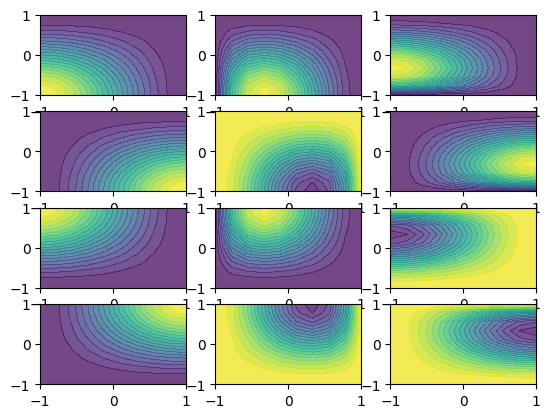

In [14]:
# hermite cubic polynomials in 2d
def get_hermite_cubic_2d(ibasis):
    # node 0 (-1,-1), node 1 (1, -1), node 2 (-1, 1), node 3 (1,1)
    if ibasis == 0: # w for node 0
        ixi, ieta = (0, 0)
    elif ibasis == 1: # dw/dx for node 0
        ixi, ieta = (1, 0)
    elif ibasis == 2: # dw/dy for node 0
        ixi, ieta = (0, 1)
    elif ibasis == 3: # w for node 1
        ixi, ieta = (2, 0)
    elif ibasis == 4: # dw/dx for node 1
        ixi, ieta = (3, 0)
    elif ibasis == 5: # dw/dy for node 1
        ixi, ieta = (2, 1)
    elif ibasis == 6: # w for node 2
        ixi, ieta = (0, 2)
    elif ibasis == 7: # dw/dx for node 2
        ixi, ieta = (1, 2)
    elif ibasis == 8: # dw/dy for node 2
        ixi, ieta = (0, 3)
    elif ibasis == 9: # w for node 3
        ixi, ieta = (2, 2)
    elif ibasis == 10: # dw/dx for node 3
        ixi, ieta = (3, 2)
    elif ibasis == 11: # dw/dy for node 3
        ixi, ieta = (2, 3)

    return ixi, ieta

def hermite_cubic_2d(ibasis, xi, eta):
    ixi, ieta = get_hermite_cubic_2d(ibasis)
    return hermite_cubic_1d(ixi, xi)  * hermite_cubic_1d(ieta, eta)

# check the hermite cubic polynomials in 4x3 grid
fig, axs = plt.subplots(4, 3)

n = 10
xi_vec = np.linspace(-1,1,n)
eta_vec = np.linspace(-1,1,n)
XI, ETA = np.meshgrid(xi_vec, eta_vec)

for inode in range(4):
    for ihermite in range(3):
        ibasis = 3 * inode + ihermite
        # print(f"{ibasis=}")
        H = np.array([[hermite_cubic_2d(ibasis, my_xi, my_eta) for my_xi in xi_vec] for my_eta in eta_vec])
        axs[inode,ihermite].contourf(XI, ETA, H, levels=20, cmap='viridis', alpha=0.75)  # Filled contours

plt.show()

In [15]:
"""
This block shows how to compute element stiffness and stability matrices for FEM panel buckling.
This is basically a library of methods that we need to solve the FEM panel buckling problem in
the next code block.
"""

import numpy as np
# from scipy.linalg import eigh
from scipy.sparse.linalg import eigs

def quadrature_rule(iquad):
    # 3x3 gauss quadrature rule
    rt = (3.0/5.0)**0.5
    vec = [-rt, 0, rt]
    # 9 quadrature points, 0-8
    # return the [xi,eta] quad pt location and w the quadrature weight
    odd = 5.0/9.0
    even = 8.0/9.0
    if iquad == 0:
        return [-rt, -rt], odd
    elif iquad == 1:
        return [0, -rt], even
    elif iquad == 2:
        return [rt, -rt], odd
    elif iquad == 3:
        return [-rt, 0], even
    elif iquad == 4:
        return [0, 0], odd
    elif iquad == 5:
        return [rt, 0], even
    elif iquad == 6:
        return [-rt, rt], odd
    elif iquad == 7:
        return [0, rt], even
    elif iquad == 8:
        return [rt, rt], odd

def get_laplacian(ibasis, xi, eta, xscale, yscale):
    ixi, ieta = get_hermite_cubic_2d(ibasis)

    xi_poly = hermite_cubic_polynomials_1d(ixi)
    eta_poly = hermite_cubic_polynomials_1d(ieta)
    xi_factor = eval_polynomial(xi_poly, xi)
    eta_factor = eval_polynomial(eta_poly, eta)

    d2xi_poly = [2.0 * xi_poly[-2], 6.0 * xi_poly[-1]]
    d2xi = eval_polynomial(d2xi_poly, xi)
    d2eta_poly = [2.0 * eta_poly[-2], 6.0 * eta_poly[-1]]
    d2eta = eval_polynomial(d2eta_poly, eta)    
    
    dphi_dxx = 1/xscale**2 * d2xi * eta_factor
    dphi_dyy = 1/yscale**2 * d2eta * xi_factor
    return dphi_dxx + dphi_dyy

def get_gradient(ibasis, xi, eta, xscale, yscale):
    # compute dphi/dx and dphi/dy for the gradient at a given xi, eta point in the isoperimetric element
    ixi, ieta = get_hermite_cubic_2d(ibasis)

    xi_poly = hermite_cubic_polynomials_1d(ixi)
    eta_poly = hermite_cubic_polynomials_1d(ieta)
    xi_factor = eval_polynomial(xi_poly, xi)
    eta_factor = eval_polynomial(eta_poly, eta)

    dxi_poly = [xi_poly[-3], 2.0 * xi_poly[-2], 3.0 * xi_poly[-1]]
    dxi = eval_polynomial(dxi_poly, xi)
    deta_poly = [eta_poly[-3], 2.0 * eta_poly[-2], 3.0 * eta_poly[-1]]
    deta = eval_polynomial(deta_poly, eta)
    
    dphi_dx = 1.0/xscale * dxi * eta_factor
    dphi_dy = 1.0 / yscale * deta * xi_factor

    return [dphi_dx, dphi_dy]

def get_kelem(D, xscale, yscale):
    """
    compute the element stiffness matrix for an element with given x and y dimensions.
    Normally xscale = dx/2 and yscale = dy/2 for jacobian conversion dX/dxi
    """

    # sum over each of the quadrature points and basis functions
    nquad = 9
    nbasis = 12
    Kelem = np.zeros((nbasis, nbasis))
    for iquad in range(nquad):
        pt, weight = quadrature_rule(iquad)
        xi = pt[0]
        eta = pt[1]
        for i in range(nbasis):
            for j in range(nbasis):
                Kelem[i,j] += D * weight * xscale * yscale * \
                get_laplacian(i, xi, eta, xscale, yscale) * \
                get_laplacian(j, xi, eta, xscale, yscale)

    # print(f"{Kelem=}")

    return Kelem

def get_gelem(Nxx, Nxy, Nyy, xscale, yscale):
    """
    compute the element stability matrix which is dependent on the in-plane loads
    """
    nquad = 9
    nbasis = 12
    Gelem = np.zeros((nbasis, nbasis))
    for iquad in range(nquad):
        pt, weight = quadrature_rule(iquad)
        xi = pt[0]
        eta = pt[1]
        for i in range(nbasis):
            for j in range(nbasis):
                grad_i = get_gradient(i, xi, eta, xscale, yscale)
                grad_j = get_gradient(j, xi, eta, xscale, yscale)
                Gelem[i,j] += weight * xscale * yscale * \
                 (Nxx * grad_i[0] * grad_j[0] + \
                  Nxy * grad_i[0] * grad_j[1] + Nxy * grad_i[1] * grad_j[0] + \
                  Nyy * grad_i[1] * grad_j[1])

    return Gelem

def solve_fem_buckling(D, a, b, Nxx, Nxy, Nyy, nxe, nye, sigma, num_eig=100):
    """
    solve the finite element panel buckling problem for metal, simply supported plate with a,b panel
    length and width respectively. The D bending stiffness material only affects scale of eigenvalue.
    """

    # generate a structured mesh of a flat plate in xy-plane
    # with panel length a (x-direction) and panel width b (y-direction)
    
    # node counts in each direction
    nnx = nxe + 1
    nny = nye + 1
    num_nodes = nnx * nny
    num_elements = nxe * nye
    nodes = [_ for _ in range(num_nodes)]

    # since rect elements the xscale, yscale is fixed and can compute here
    xscale = a / nxe
    yscale = b / nye

    # and we can also pre-compute the Kelem and Gelem (same for every element)
    Kelem = get_kelem(D, xscale, yscale)
    Gelem = get_gelem(Nxx, Nxy, Nyy, xscale, yscale)

    # basis or dof connectivity of the element (which dof are in this element)
    dof_conn = []
    for iy in range(nye):
        for ix in range(nxe):
            istart = 3 * ix + 3 * nnx * iy
            istart2 = istart + 3 * nnx

            # 4 nodes in each element (same order as basis functions)
            dof_conn += [
                [istart+ind for ind in range(6)] + [istart2+ind for ind in range(6)]
            ]

    # now assemble global stiffness matrix Kglobal
    num_dof = 3 * num_nodes # since we have w, dw/dx and dw/dy 3 dof per node
    Kmat = np.zeros((num_dof, num_dof))
    Gmat = np.zeros((num_dof, num_dof))

    for ielem in range(num_elements):
        local_conn = np.array(dof_conn[ielem])
        # print(f"{local_conn.shape=} {Kelem.shape=}")
        # assembly (add Kelem into correct node locations of global matrix)
        np.add.at(Kmat, (local_conn[:, None], local_conn[None, :]), Kelem)
        np.add.at(Gmat, (local_conn[:, None], local_conn[None, :]), Gelem)

    # now apply BCs to the problem
    bcs = []
    for iy in range(nny):
        for ix in range(nnx):
            inode = iy * nnx + ix
            w_idof = 3 * inode
            if ix == 0 or ix == nnx - 1 or iy == 0 or iy == nny-1:
                bcs += [w_idof]
    
    # print(f"{bcs=}")

    # preferred for scipy linear algebra solvers to get reduced stiffness matrix and stability matrix instead
    free_dofs = [idof for idof in range(num_dof) if not(idof in bcs)]

    Kred = Kmat[np.ix_(free_dofs, free_dofs)]
    Gred = Gmat[np.ix_(free_dofs, free_dofs)]

    # print(f"{np.any(np.isnan(Kred))=}")
    # print(f"{np.any(np.isnan(Gred))=}")

    # at one point diagonal of K had some zeros (clear error because conn didn't go all the way up to full # nodes)
    # print(f"{np.diag(Kred)=}")
    # print(f"{np.diag(Gred)=}")

    # since these matrices are symmetric use eigh solver
    # this approach didn't work since Gred was not positive definite and this solver can't handle that
    # eigenvalues, eigenvectors = eigh(Kred, Gred)

    # Shift-invert solver instead to handle neg definite Gmat
    # sigma = 0.1  # Adjust based on expected eigenvalues
    # k = 6 is default
    eigenvalues, eigenvectors = eigs(A=Kred, M=Gred, sigma=sigma, k=num_eig, which='LM')
    # print(f"{eigenvalues=}")

    # num_eig = eigenvalues.shape[0]
    # print(f"{eigenvectors.shape=}")
    full_eigenvectors = []
    for ieig in range(num_eig):
        phi = np.zeros((num_dof,))
        phi[free_dofs[:]] = eigenvectors[:, ieig]
        full_eigenvectors += [phi]

    # compute 

    return eigenvalues, full_eigenvectors
    
def plot_eigenvec(a, b, nxe, nye, phi):
    """
    plot the eigenvector on the plate
    """

    import matplotlib.pyplot as plt
    
    # node counts in each direction
    nnx = nxe + 1
    nny = nye + 1
    num_nodes = nnx * nny
    nodes = [_ for _ in range(num_nodes)]
    w_phi = phi[::3]

    x = np.linspace(0.0, a, nnx)
    y = np.linspace(0.0, b, nny)
    X, Y = np.meshgrid(x, y)
    W = np.reshape(w_phi, newshape=(nnx, nny))

    plt.figure(figsize=(8, 6))
    # contours = plt.contour(X, Y, W, levels=20, cmap='viridis')  # Line contours
    colors = plt.contourf(X, Y, W, levels=20, cmap='viridis', alpha=0.75)  # Filled contours
    plt.colorbar(colors, label="phi(x,y)")  # Colorbar for reference
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    # plt.title("2D Contour Plot")
    plt.show()

pred_buckling_load=31633.29400032052


/tmp/ipykernel_279061/1971657322.py:207: ComplexWarning: Casting complex values to real discards the imaginary part
  phi[free_dofs[:]] = eigenvectors[:, ieig]


min_rel_err=0.011882462259222775
dt=110.15980172157288 seconds
lam[i]=(16.106196001962264+0j)


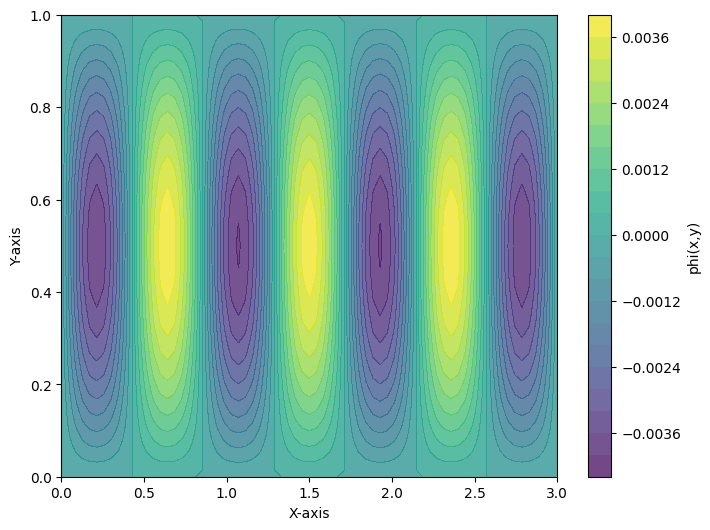

lam[i]=(13.354442649352476+0j)


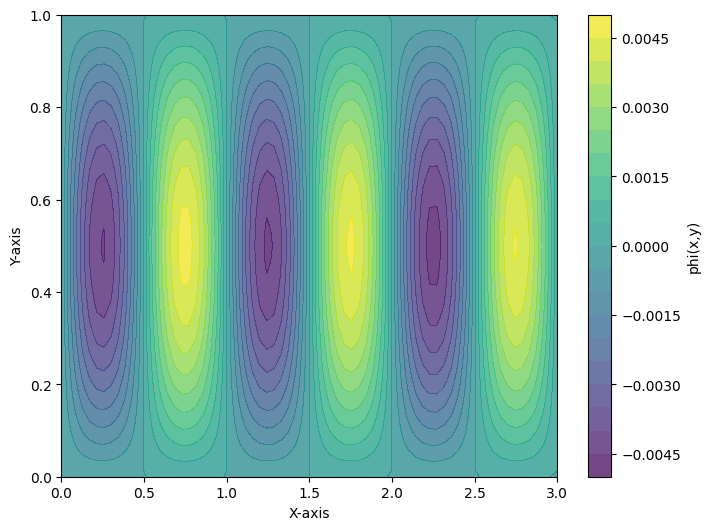

lam[i]=(19.349463934211464+0j)


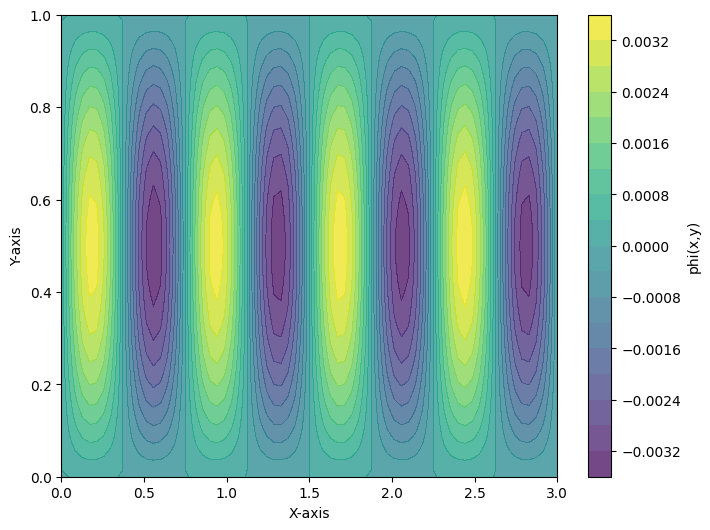

lam[i]=(11.133344839216852+0j)


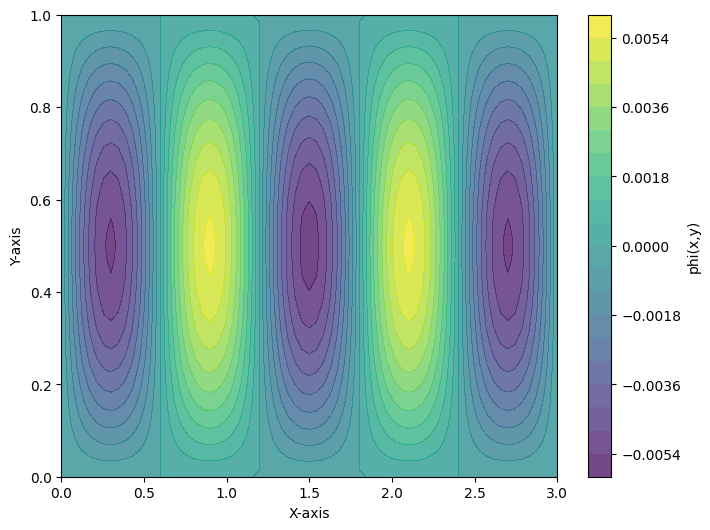

lam[i]=(10.218086911861851+0j)


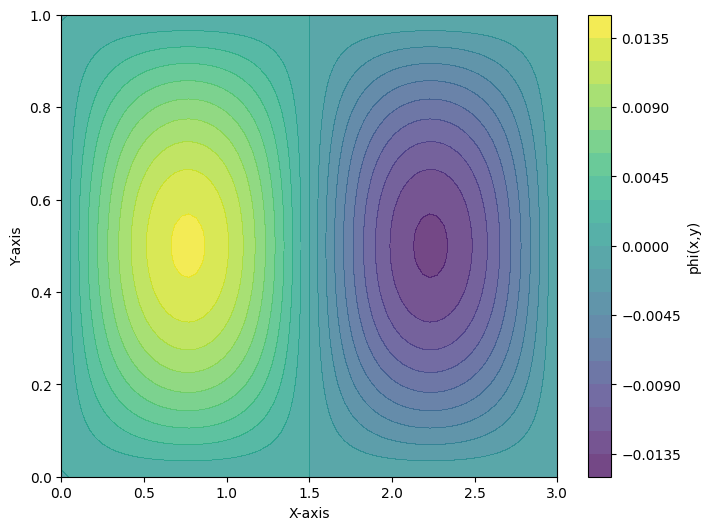

lam[i]=(9.538452277967322+0j)


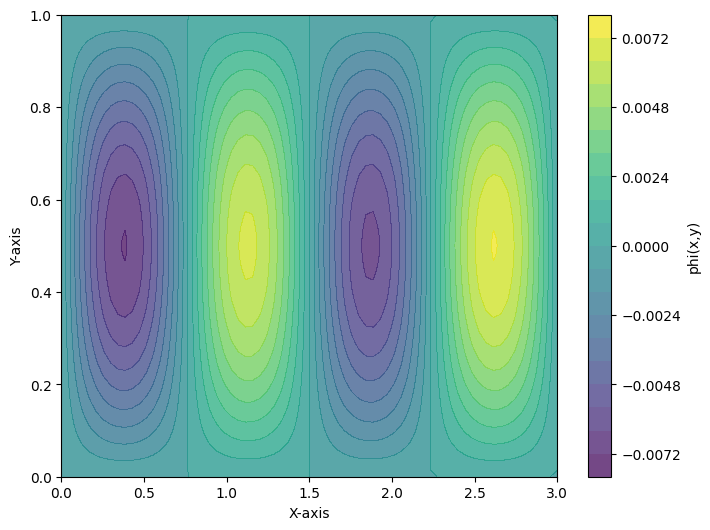

lam[i]=(8.8532657438144+0j)


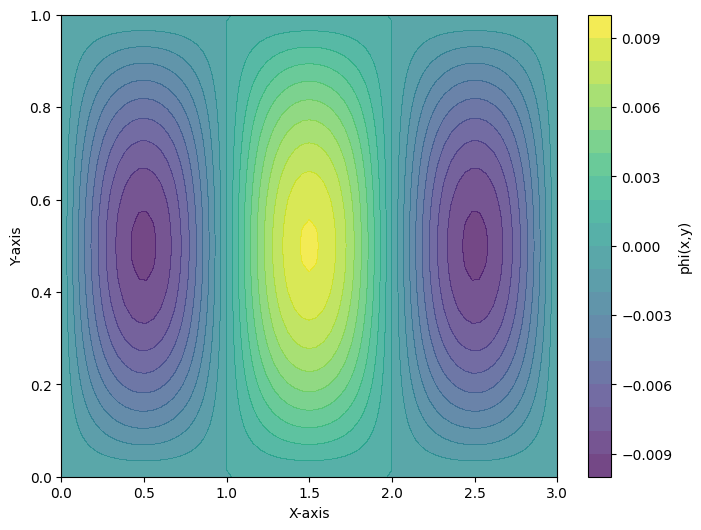

lam[i]=(23.06818950410498+0j)


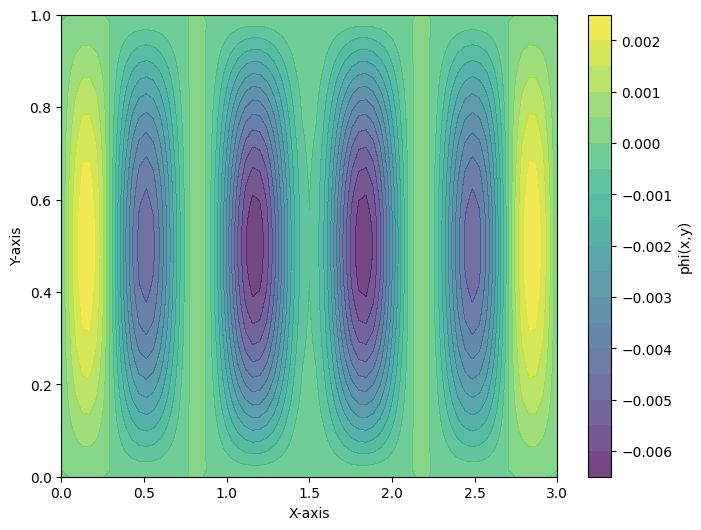

lam[i]=(22.895646591731456+0j)


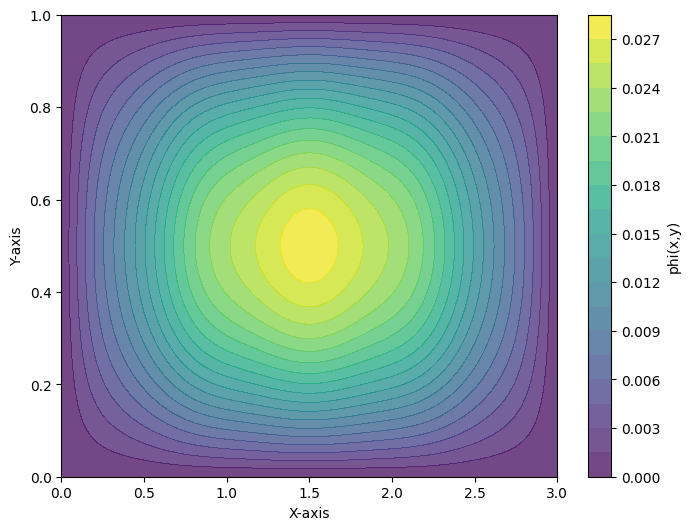

lam[i]=(27.244642134542595+0j)


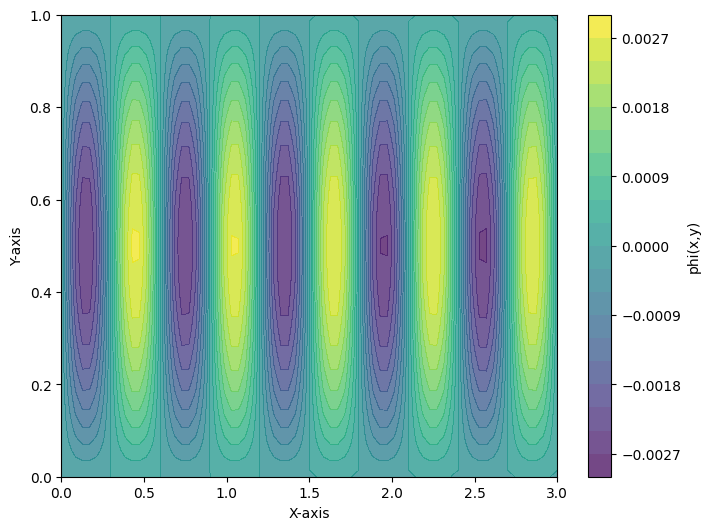

In [16]:
# try actually solving the problem here
from scipy.optimize import fsolve
import time

# aluminum plate material properties
E = 70e9; nu = 0.3; thick = 0.005
D = E * thick**3 / 12.0 / (1 - nu**2)
# D = 1

# choose loading type (first just uniaxial loading in x-direction)
# axial = True
axial = True
if axial:
    Nxx, Nxy, Nyy = (1e3, 0, 0)
else:
    Nxx, Nxy, Nyy = (0, 1e2, 0)
# Nxx, Nxy, Nyy = (0, 0, 1e3)

# choose mesh size by # elements each direction
# nxe = 10; nye = 10
# nxe = 2; nye = 2
# nxe, nye = (10, 10)
# nxe, nye = (30, 30)
# nxe, nye = (50, 50)
(nxe, nye) = (70, 70)
# nxe, nye = (100, 100)

# choose geometry of plate
# a, b = (1,1)
a, b = (3,1)

# predict the buckling load for axial case
pi = 3.14159
if axial:
    pred_buckling_load = pi**2 * D / b**2 * 4.0 
    pred_load_factor = pred_buckling_load / Nxx
    sigma = 0.5 * pred_load_factor
    print(f"{pred_buckling_load=}")

# TODO : pred buckling load for shear case
if not axial:
    def resid(_s2):
        s1_sq = np.sqrt(1.0 + 2.0 * _s2**2 + _s2**4)
        return s1_sq + _s2**2 + 1.0/3.0 - np.sqrt(4.0/9.0 + 4.0/3.0 * s1_sq + 4.0/3.0 * s1_sq**2)

    s2_soln = fsolve(resid, x0=1.0)
    print(f"{s2_soln=}")
    s2 = s2_soln[0]
    s1_sq = np.sqrt(1.0 + 2.0 * s2**2 + s2**4)
    s2_resid = resid(s2)
    print(f"{s2_resid=}")

    # sean's closed-form soln for shear
    pred_buckling_load_star = (1.0 + s1_sq**2 + 6 * s1_sq * s2**2 + s2**4 + 2.0 * (s1_sq + s2**2)) / 2.0 / (s1_sq * s2**2)
    rho = a / b
    ar_factor = np.max([1.0, 1.0/rho**2])
    pred_buckling_load = pi**2 * D / b**2 * pred_buckling_load_star * ar_factor
    
    # from chatgpt pred_buckling_load for shear, simply supported (first estimate)
    # pred_buckling_load = 4 * E / 2.0 / (1 + nu) / thick**2 / (1 - nu**2)
    pred_load_factor = pred_buckling_load / Nxy
    sigma = 0.9 * pred_load_factor
    # sigma = 0.1
    print(f"{pred_load_factor=}")
    # sigma = 50.0

start_time = time.time()

# try and solve the FEM buckling problem
lam, phi = solve_fem_buckling(D, a, b, Nxx, Nxy, Nyy, nxe, nye, sigma=sigma, num_eig=100)

# true solution is sin(3*pi*x)

def get_rel_err(iphi):
    # compute relative error against the true solution
    w_phi = phi[iphi][::3]
    nnx = nxe + 1; nny = nye + 1
    x = np.linspace(0.0, a, nnx)
    y = np.linspace(0.0, b, nny)
    X, Y = np.meshgrid(x, y)
    W = np.reshape(w_phi, newshape=(nnx, nny))

    if axial:
        true_W = np.sin(np.pi * X) * np.sin(np.pi * Y) * np.max(np.abs(np.real(w_phi)))
    else: # shaer
        true_W = W * 0.0

    abs_diff = np.max(np.abs(W - true_W))
    rel_err = abs_diff / np.max(np.abs(true_W))

    # colors = plt.contourf(X, Y, W, levels=20, cmap='viridis', alpha=0.75)  # Filled contours
    # plt.colorbar(colors, label="w(x,y)")  # Colorbar for reference
    # plt.show()

    # colors = plt.contourf(X, Y, true_W, levels=20, cmap='viridis', alpha=0.75)  # Filled contours
    # plt.colorbar(colors, label="w_true(x,y)")  # Colorbar for reference
    # plt.show()

    # colors = plt.contourf(X, Y, -1.0 * true_W, levels=20, cmap='viridis', alpha=0.75)  # Filled contours
    # plt.colorbar(colors, label="-w_true(x,y)")  # Colorbar for reference
    # plt.show()

    true_W2 = -1.0 * true_W # flipped sign
    abs_diff2 = np.max(np.abs(W - true_W2))
    rel_err2 = abs_diff2 / np.max(np.abs(true_W2))

    # if iphi == 7:
    #     print(f"{abs_diff=} {rel_err=}")
    #     print(f"{abs_diff2=} {rel_err2=}")
    return min([rel_err, rel_err2])

# get_rel_err(7)
# exit(0)

num_eig = 10
rel_errs = [get_rel_err(i) for i in range(num_eig)]
min_rel_err = min(rel_errs)
print(f"{min_rel_err=}")

end_time = time.time()
dt = end_time - start_time
print(f"{dt=} seconds")

# rel_errs = []
for i in range(num_eig):
    print(f"{lam[i]=}")
    plot_eigenvec(a, b, nxe, nye, phi[i])
    # rel_errs += [get_rel_err(i)]

# min_rel_err = min(rel_errs)
# print(f"{min_rel_err=}")

# imin = np.argmin(np.abs(np.real(lam)))
# # imin = 0
# lam_min = lam[imin]
# print(f"{lam=}")
# print(f"{lam_min=}")
# phi_min = phi[imin]
# num_eig = lam.shape[0]
# print(f"{num_eig=}")
# plot_eigenvec(a, b, nxe, nye, phi_min)
